In [1]:
import pandas as pd # dataframe manipulation
import numpy as np # data manipulation
import lucem_illud_2020 # for word tokenizing
import pickle # data storage and retrieval
import gensim # doc2vec model building
import sklearn.metrics # cosine similarity
from collections import defaultdict # for handling dictionary more easily
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import scipy.stats # for correlation calculation
import sklearn.cluster # for kmeans
import sklearn.decomposition # for visualizing kmeans result
from itertools import combinations # for getting author combinations

# Loading Data

In [2]:
# getting the data created from `1_Data Accumulation and Cleaning.ipynb`
df = pd.read_pickle('data/tokenized_data.pkl')
author_document_count = pd.read_csv('data/author_documents_count.csv')
with open('data/doc_annon_dict', 'rb') as f:
    doc_annon_dict = pickle.load(f)
with open('data/annon_doc_dict', 'rb') as f:
    annon_doc_dict = pickle.load(f)

## concatenating survey data

Note that I am not saving this anywhere to confirm with annonymity agreement

In [4]:
# link the annonimized author ID to the survey IDs
double_blind = pd.read_csv('rawdata/survey/doubleBlind.csv', index_col=0)
double_blind.columns = ['surveyCode', 'author']
author_documents_count = pd.read_csv('data/author_documents_count.csv')
survey_result = author_documents_count.merge(double_blind)

# get the survey results and merge it with the annonimized author ID
survey_raw = pd.read_csv('rawdata/survey/data_mass_2018-08-30_18-40-09.csv')
survey_raw = survey_raw.rename(columns={'Unnamed: 0':'surveyCode'})
survey_result = survey_result.merge(survey_raw)

# only subset the columns to use
survey_result = survey_result[['author', 'docnum', 'abstract_docnum', 'surveyCode',
                               't_cmpt', 't_comp', 't_ctxt', 't_ess', 't_evo', 't_hol', 't_lg', 't_mth',
                               't_nat', 't_neur', 't_perc', 't_rat', 't_rch', 't_rlsm', 't_soc', 't_univ']]

# relabeling to the acutal variable names
survey_result.columns = ['author', 'docnum', 'abstract_docnum', 'surveyCode',
                         'competence', 'computer', 'context', 'essentialism', 'evolution', 'holism', 'language', 'math',
                         'nature', 'neurobiology', 'perception', 'rationality', 'reach', 'realism', 'society', 'universality']

# free up some memory
del survey_raw

## survey descriptive statistics

In [42]:
for var in survey_result.columns[4:20]:
    var_col = survey_result.loc[:, var]
    print(f'for variable {var}: mean={var_col.mean()}, standard deviation={var_col.std()}, median={var_col.median()}, count:{sum(~var_col.isna())}')

for variable competence: mean=50.85126050420168, standard deviation=21.013164815658982, median=50.0, count:5950
for variable computer: mean=29.341008403361343, standard deviation=23.05867851572392, median=25.0, count:5950
for variable context: mean=68.87781512605042, standard deviation=20.724976594249267, median=71.0, count:5950
for variable essentialism: mean=53.849915966386554, standard deviation=22.75029430356829, median=60.0, count:5950
for variable evolution: mean=48.92638655462185, standard deviation=25.22281862673913, median=50.0, count:5950
for variable holism: mean=58.2527731092437, standard deviation=22.460745643161854, median=60.0, count:5950
for variable language: mean=62.567563025210085, standard deviation=23.66195481162657, median=66.0, count:5950
for variable math: mean=43.194621848739494, standard deviation=27.742078135818478, median=40.0, count:5950
for variable nature: mean=50.300504201680674, standard deviation=24.24957329709482, median=50.0, count:5950
for variable 

# Building the Doc2Vec model

Using WOS ID (unique for document) and annonimized author IDs (unique for author) as the tags

In [5]:
# building the taggedDocs row in the dataframe
taggedDocs = []
for index, row in df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [row['wos_id']] # WOS ID (unique for document) as a tag
    docKeywords += doc_annon_dict[row['wos_id']] # adding annonimized author IDs as tags
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_words'], tags = docKeywords))
df['TaggedTexts'] = taggedDocs

In [14]:
%%time
d2v_whole = gensim.models.doc2vec.Doc2Vec(df['TaggedTexts'])

Wall time: 11min 26s


In [3]:
d2v_whole.save('models/d2v_whole')

## Sanity Check - printing out some values

In [8]:
d2v_whole.wv.most_similar('depression')

[('depressive', 0.6652538180351257),
 ('mdd', 0.6455171704292297),
 ('depressiveness', 0.6383962631225586),
 ('dysthymia', 0.6335387229919434),
 ('depressed', 0.5867753028869629),
 ('gryllotalpa', 0.5815899968147278),
 ('depressions', 0.5779390335083008),
 ('dysphoria', 0.5774984955787659),
 ('gad', 0.5696401596069336),
 ('mde', 0.5607605576515198)]

In [9]:
d2v_whole.wv.most_similar('memory')

[('wm', 0.6516883373260498),
 ('nonworking', 0.5788607001304626),
 ('stm', 0.5738449692726135),
 ('memories', 0.5695767402648926),
 ('vwm', 0.5666775107383728),
 ('recall', 0.5551853775978088),
 ('vstm', 0.5404012799263),
 ('compulsively', 0.5357964038848877),
 ('vts', 0.5343604683876038),
 ('epf', 0.5272419452667236)]

In [10]:
d2v_whole.wv.most_similar('qualitative')

[('ethnographic', 0.6859760880470276),
 ('phenomenological', 0.6517402529716492),
 ('quantitative', 0.6378465890884399),
 ('interpretative', 0.5775237083435059),
 ('exploratory', 0.5724530220031738),
 ('phenomenographic', 0.5696792602539062),
 ('indepth', 0.5671736598014832),
 ('triangulated', 0.5425319671630859),
 ('participatory', 0.540313720703125),
 ('cqr', 0.529847264289856)]

In [21]:
d2v_whole.wv.most_similar('qualitative')

[('quantitative', 0.6881126165390015),
 ('descriptive', 0.6509861946105957),
 ('phenomenological', 0.6446052193641663),
 ('exploratory', 0.6389240622520447),
 ('ethnographic', 0.6349052786827087),
 ('phenomenographic', 0.568645179271698),
 ('interpretative', 0.5595908164978027),
 ('detailed', 0.5595217943191528),
 ('methodology', 0.5582003593444824),
 ('depth', 0.5524240732192993)]

In [22]:
d2v_whole.wv.most_similar('quantitative')

[('qualitative', 0.6881126761436462),
 ('descriptive', 0.6447649598121643),
 ('systematic', 0.6130667924880981),
 ('methodology', 0.5913326144218445),
 ('detailed', 0.5838874578475952),
 ('observational', 0.5249171853065491),
 ('methods', 0.5246598720550537),
 ('idiographic', 0.5171036124229431),
 ('categorical', 0.5113418102264404),
 ('comparative', 0.5095191597938538)]

# Sanity checking - comparing average of document with authors

In [17]:
# the key 'jO~' correspond to a random author that had 51 documents attached
doc_vecs = []
for wos_id in annon_doc_dict['jOtzpHFUWDhSyFWME']:
    try:
        doc_vecs.append(d2v_whole[wos_id])
    except:
        pass
# checking that the number of documents mathces
len(doc_vecs)

51

In [18]:
sklearn.metrics.pairwise.cosine_similarity(d2v_whole['jOtzpHFUWDhSyFWME'].reshape(1, -1), 
                                           np.average(doc_vecs, axis=0).reshape(1, -1))

array([[0.9996871]], dtype=float32)

The averaged vector of documents and author vector seems pretty much identical!

# author similarities

## cosine similarity based on doc2vec vectors vs survey vectors

In [5]:
# concatenating the survey results to a vector
survey_result['survey_vector'] = survey_result.apply(lambda x: np.array(x[4:20]), axis=1)

In [6]:
# switch to numpy since it is faster
# still takes about 4 hours to run
survey_result_np = survey_result[['author', 'survey_vector']].to_numpy()

# initialize lists to store the results
author1 = []
author2 = []
d2v_cos_sims = []
survey_cos_sims = []
# iterate through all combinations of authors
for combi in combinations(survey_result['author'], 2):
    # get the names of authors, d2v vectors, survey vectors
    a1 = combi[0]
    a1_d2v_vec = d2v_whole[a1]
    a1_survey_vec = survey_result_np[survey_result_np[:, 0] == a1][0][1]
    a2 = combi[1]
    a2_d2v_vec = d2v_whole[a2]
    a2_survey_vec = survey_result_np[survey_result_np[:, 0] == a2][0][1]
    
    # append the result
    author1.append(a1)
    author2.append(a2)
    d2v_cos_sims.append(sklearn.metrics.pairwise.cosine_similarity(a1_d2v_vec.reshape(1,-1), 
                                                                   a2_d2v_vec.reshape(1,-1))[0][0])
    survey_cos_sims.append(sklearn.metrics.pairwise.cosine_similarity(a1_survey_vec.reshape(1,-1), 
                                                                      a2_survey_vec.reshape(1,-1))[0][0])

# build a dataframe to store the results
cos_sim_df = pd.DataFrame()
cos_sim_df['Author_1'] = author1
cos_sim_df['Author_2'] = author2
cos_sim_df['d2v_cos_sims'] = d2v_cos_sims
cos_sim_df['survey_cos_sims'] = survey_cos_sims

In [11]:
cos_sim_df.to_csv('results/cos_sim_d2v_survey.csv')

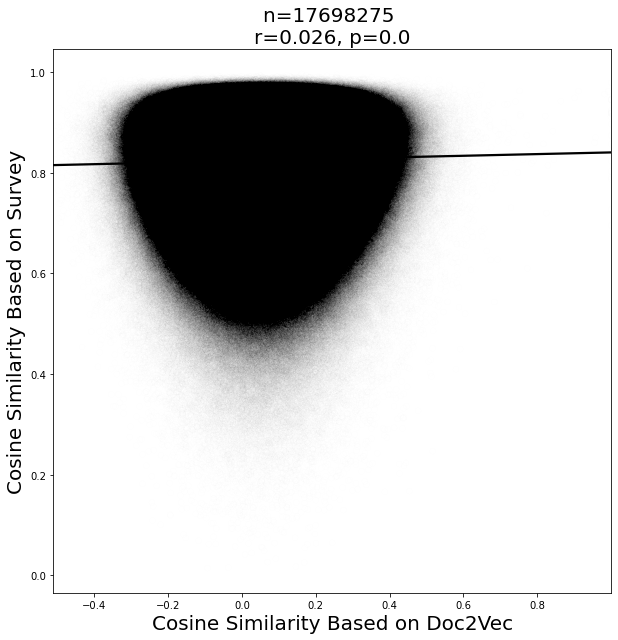

In [22]:
# plotting scatterplot with regression line
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(data=cos_sim_df, x='d2v_cos_sims', y='survey_cos_sims',
            scatter_kws={'alpha':0.005, 'facecolor':"None",
                                 'edgecolor':'black'},
            line_kws={'color':'black'},
            ax=ax)
coer = np.round(scipy.stats.pearsonr(cos_sim_df['d2v_cos_sims'], cos_sim_df['survey_cos_sims']), 3)
ax.set_title(f'n={cos_sim_df.shape[0]} \nr={coer[0]}, p={coer[1]}', size=20)
ax.set_xlabel('Cosine Similarity Based on Doc2Vec', size=20)
ax.set_ylabel('Cosine Similarity Based on Survey', size=20)
plt.savefig('figures/author_d2v_survey_cos_sim.png')

# Clustering of authors

## k-means using doc2vec vectors vs k-means using survey vectors

Finding the best k to try out by calculating silhouette scores:

In [45]:
# modified function from the class jupyter notebook
def calculate_best_silhouette(vecs, max_num):
    for num in range(2, max_num):
        km = sklearn.cluster.KMeans(n_clusters=num, init='k-means++')
        km.fit(vecs)
        cluster_labels = km.fit_predict(vecs)
        print(f'for cluster number of {num}, the silhouette score is: {sklearn.metrics.silhouette_score(vecs, cluster_labels)}')

In [46]:
# getting the doc2vec vectors
d2v_vectors = []
for author in survey_result['author']:
    d2v_vectors.append(d2v_whole[author])
# saving the doc2vec vectors
d2v_vecs = np.vstack(d2v_vectors)
# calculating silhouette values
calculate_best_silhouette(vecs=d2v_vecs, max_num=21)

for cluster number of 2, the silhouette score is: 0.43439576029777527
for cluster number of 3, the silhouette score is: 0.4299508333206177
for cluster number of 4, the silhouette score is: 0.400481641292572
for cluster number of 5, the silhouette score is: 0.33830955624580383
for cluster number of 6, the silhouette score is: 0.38341304659843445
for cluster number of 7, the silhouette score is: 0.2218632847070694
for cluster number of 8, the silhouette score is: 0.2543011009693146
for cluster number of 9, the silhouette score is: 0.25515905022621155
for cluster number of 10, the silhouette score is: 0.12988200783729553
for cluster number of 11, the silhouette score is: 0.21995851397514343
for cluster number of 12, the silhouette score is: 0.15698635578155518
for cluster number of 13, the silhouette score is: 0.19888655841350555
for cluster number of 14, the silhouette score is: 0.20702767372131348
for cluster number of 15, the silhouette score is: 0.10339443385601044
for cluster number 

In [47]:
# survey_vector was calculated above
survey_vecs = np.vstack(survey_result['survey_vector'])
# calculating silhouette values
calculate_best_silhouette(vecs=survey_vecs, max_num=21)

for cluster number of 2, the silhouette score is: 0.09532078983135339
for cluster number of 3, the silhouette score is: 0.07280672103713239
for cluster number of 4, the silhouette score is: 0.06378324905193863
for cluster number of 5, the silhouette score is: 0.06092222043366799
for cluster number of 6, the silhouette score is: 0.05590314420795213
for cluster number of 7, the silhouette score is: 0.05245884324295942
for cluster number of 8, the silhouette score is: 0.05232347115446719
for cluster number of 9, the silhouette score is: 0.04932123059696692
for cluster number of 10, the silhouette score is: 0.049127926029881135
for cluster number of 11, the silhouette score is: 0.04785811476243632
for cluster number of 12, the silhouette score is: 0.05024186651081194
for cluster number of 13, the silhouette score is: 0.04721849720440326
for cluster number of 14, the silhouette score is: 0.046979856951581155
for cluster number of 15, the silhouette score is: 0.04545870144141219
for cluster 

k = 2, 3, 4 looks like the three best ks, so I will try them out:

In [48]:
# helper function
def compare_clusters_kmeans(num_clusters, vectors1, vectors2):
    # fit the kmeans
    km1 = sklearn.cluster.KMeans(n_clusters=num_clusters, init='k-means++')
    km1.fit(vectors1)
    km2 = sklearn.cluster.KMeans(n_clusters=num_clusters, init='k-means++')
    km2.fit(vectors2)
    # print the scores
    print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(km1.labels_, km2.labels_)))
    print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(km1.labels_, km2.labels_)))
    print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(km1.labels_, km2.labels_)))
    print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(km1.labels_, km2.labels_)))
    # return the labels
    return km1.labels_, km2.labels_

In [49]:
d2v_labels_2, survey_labels_2 = compare_clusters_kmeans(num_clusters=2, vectors1=d2v_vecs, vectors2=survey_vecs)

Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand Score: -0.002


In [50]:
d2v_labels_3, survey_labels_3 = compare_clusters_kmeans(num_clusters=3, vectors1=d2v_vecs, vectors2=survey_vecs)

Homogeneity: 0.008
Completeness: 0.005
V-measure: 0.006
Adjusted Rand Score: -0.003


In [51]:
d2v_labels_4, survey_labels_4 = compare_clusters_kmeans(num_clusters=4, vectors1=d2v_vecs, vectors2=survey_vecs)

Homogeneity: 0.009
Completeness: 0.005
V-measure: 0.006
Adjusted Rand Score: 0.004


# visualization

In [57]:
# fit the PCA individually for two vector sets for visualization
pca_d2v = sklearn.decomposition.PCA(n_components = 2).fit(d2v_vecs)
reduced_data_d2v = pca_d2v.transform(d2v_vecs)
pca_survey = sklearn.decomposition.PCA(n_components = 2).fit(survey_vecs)
reduced_data_survey = pca_survey.transform(survey_vecs)

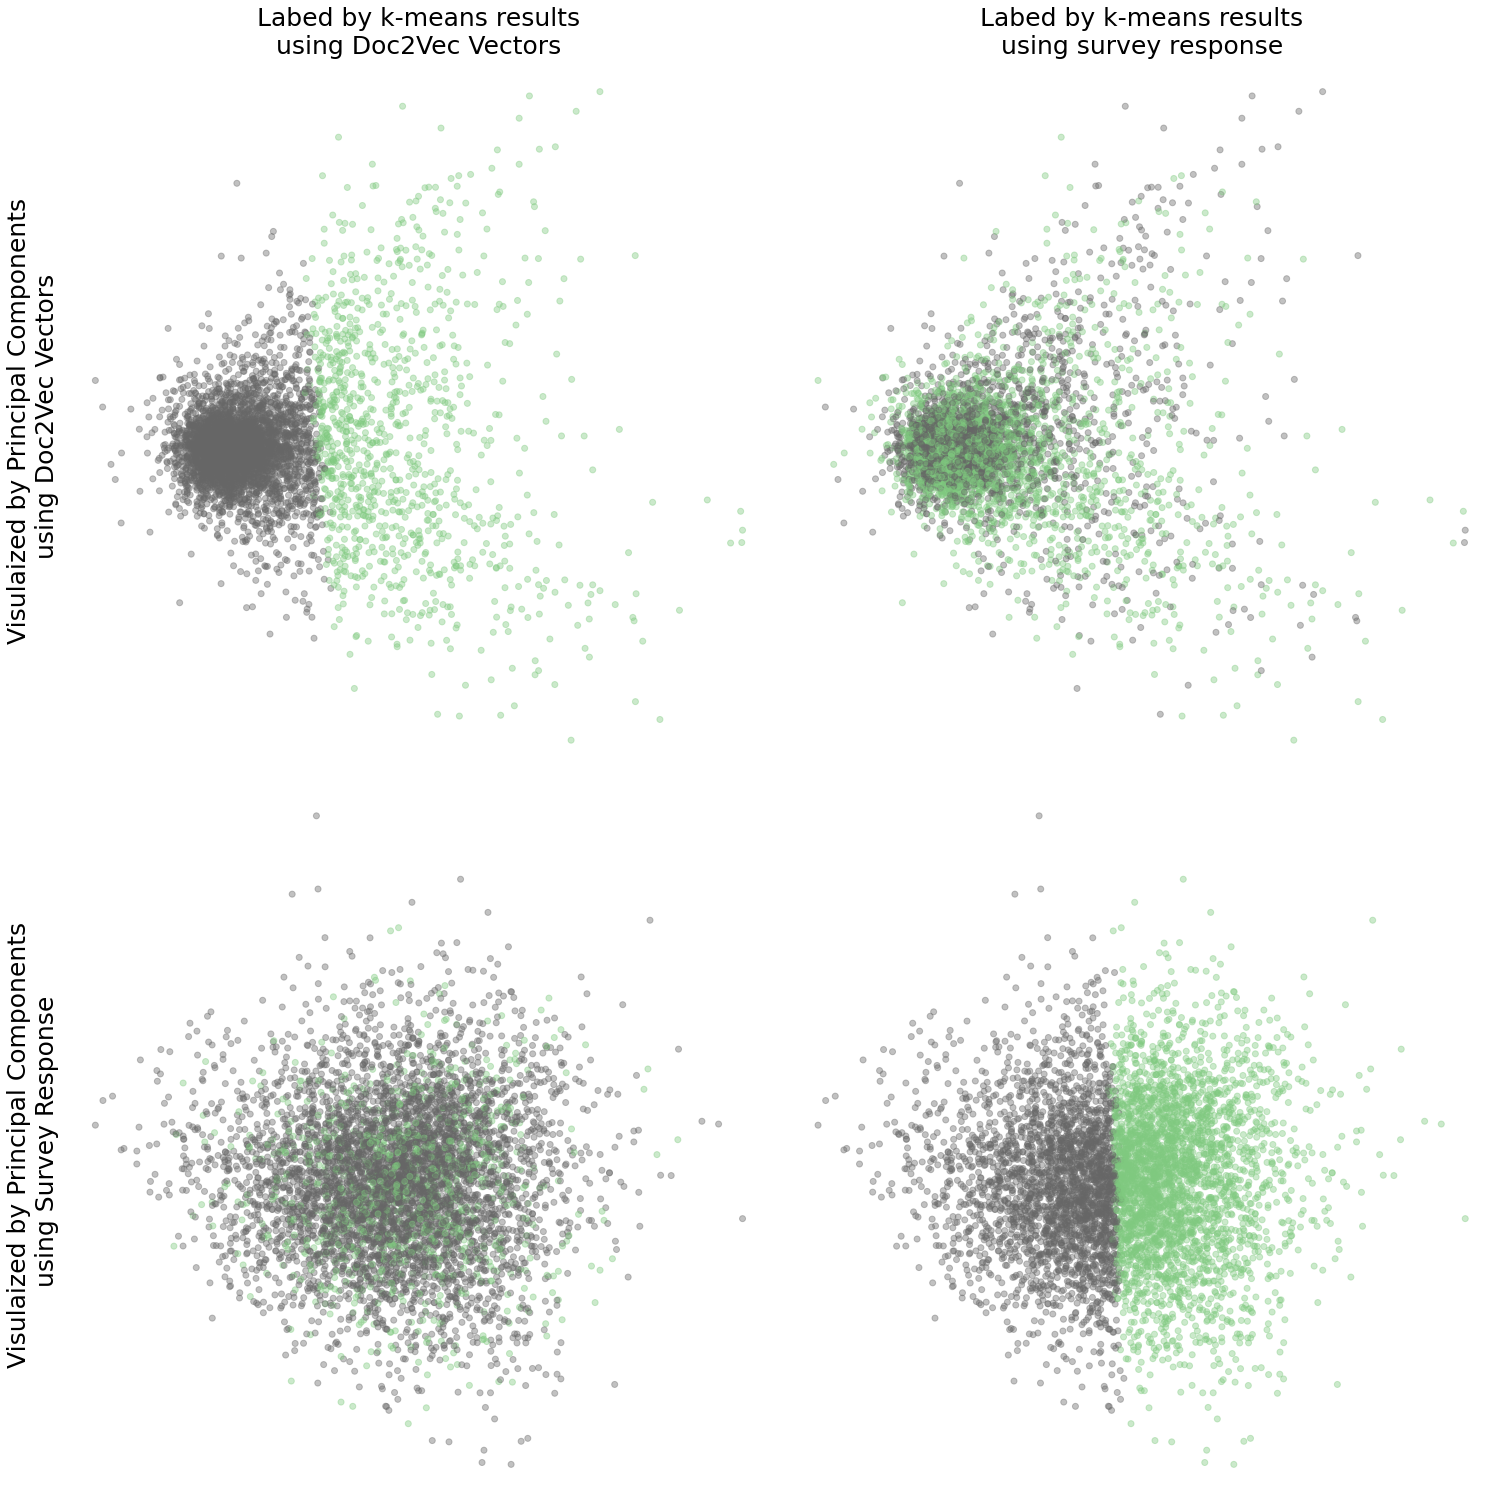

In [68]:
fig, ax = plt.subplots(figsize = (21,21), ncols=2, nrows=2)
plt.subplots_adjust(wspace = 0, hspace = 0)

# label: d2v, visualization: d2v
ax[0][0].set_frame_on(False)
ax[0][0].scatter(reduced_data_d2v[:, 0], reduced_data_d2v[:, 1], c = d2v_labels_2, alpha = 0.4, cmap=plt.get_cmap('Accent'))
ax[0][0].set_xticks(())
ax[0][0].set_yticks(())
ax[0][0].set_ylabel('Visulaized by Principal Components \nusing Doc2Vec Vectors', fontsize=25)
ax[0][0].set_title('Labed by k-means results\nusing Doc2Vec Vectors', fontsize=25)
plt.tight_layout()

# label: survey, visualization: d2v
ax[0][1].set_frame_on(False)
ax[0][1].scatter(reduced_data_d2v[:, 0], reduced_data_d2v[:, 1], c = survey_labels_2, alpha = 0.4, cmap=plt.get_cmap('Accent'))
ax[0][1].set_xticks(())
ax[0][1].set_yticks(())
ax[0][1].set_title('Labed by k-means results\nusing survey response', fontsize=25)
plt.tight_layout()

# label: d2v, visualization: survey
ax[1][0].set_frame_on(False)
ax[1][0].scatter(reduced_data_survey[:, 0], reduced_data_survey[:, 1], c = d2v_labels_2, alpha = 0.4, cmap=plt.get_cmap('Accent'))
ax[1][0].set_xticks(())
ax[1][0].set_yticks(())
ax[1][0].set_ylabel('Visulaized by Principal Components \nusing Survey Response', fontsize=25)
plt.tight_layout()

# label: survey, visualization: survey
ax[1][1].set_frame_on(False)
ax[1][1].scatter(reduced_data_survey[:, 0], reduced_data_survey[:, 1], c = survey_labels_2, alpha = 0.4, cmap=plt.get_cmap('Accent'))
ax[1][1].set_xticks(())
ax[1][1].set_yticks(())
plt.tight_layout()
plt.savefig('figures/author_d2v_survey_kmeans.png')